In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import os
import os.path
from os import path
import tensorflow as tf
from keras.models import Sequential, Model 
from keras.layers import *
import keras.backend as k
import keras.utils
from keras import optimizers as opt
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator


print(k.image_dim_ordering())

k.set_image_dim_ordering('tf')

#tf.keras

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


tf


In [152]:
def bnormalize(arr):
    arrMin = np.amin(arr)
    arrMax = np.amax(arr)
    print(arrMin)
    print(arrMax)
    if arrMax != 0:
        arr = np.subtract(arr,arrMin)
        #print(arr)
        arrMax = np.amax(arr)
        arr = np.divide(arr,arrMax)
        #print(arr)
    else:
        print("error, max value is zero")
    print("normalized")
    return arr

In [3]:
# Batch Generator

import keras.utils
import scipy.ndimage

batch_size=3
max_rotation_angle = 10
max_shift = 0.2
max_zoom = 0.2

class BatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(128, 128, 128),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        print("Generator created for image size: {}".format(self.image_dimensions))
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
        #print(self.x.shape)
        #print(self.y.shape)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        #print(batch_indices)
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            #print(i)
            if flip_flag == 1:
                x[i,:,:,:,:] = np.flip(self.x[batch_indices[i],:,:,:,:], axis=0)
                y[i,:,:,:]   = np.flip(self.y[batch_indices[i],:,:,:,0], axis=0)
            else:
                x[i,:,:,:,:] = self.x[batch_indices[i],:,:,:,:]
                y[i,:,:,:]   = self.y[batch_indices[i],:,:,:,0]
            
        # Rotations
        
        x_rot = np.copy(x)
        y_rot = np.copy(y)
            
        for i in range(self.batch_size):
            #print("aug",i)
            angle_x = np.random.randint(-max_rotation_angle, max_rotation_angle)
            x_rot[i,:,:,:,:] = scipy.ndimage.interpolation.rotate(
                x[i,:,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
            y_rot[i,:,:,:] = scipy.ndimage.interpolation.rotate(
                y[i,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
        
            #angle_y = np.random.randint(-max_rotation_angle, max_rotation_angle)
            #x_rot = scipy.ndimage.interpolation.rotate(x, angle_y, (0,2), False, mode="constant", cval=0, order=0)
            #y_rot = scipy.ndimage.interpolation.rotate(y, angle_y, (0,2), False, mode="constant", cval=0, order=0)

            #angle_z = np.random.randint(-max_rotation_angle, max_rotation_angle)
            #x_rot = scipy.ndimage.interpolation.rotate(x, angle_z, (0,1), False, mode="constant", cval=0, order=0)
            #y_rot = scipy.ndimage.interpolation.rotate(y, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        
        # shift
        
        shift = np.random.uniform(-max_shift, max_shift, size=5)
        shift[0] = 0.0
        shift[4] = 0.0
        # x_shift = scipy.ndimage.interpolation.shift(x_rot, shift)
        # y_shift = scipy.ndimage.interpolation.shift(y_rot, shift[:4])
        
        # make sure values are between 0 and 1
        
        # x_aug = np.clip(x_shift, 0.0, 1.0)
        # y_aug = np.clip(y_shift, 0.0, 1.0)
        
        x_aug = np.clip(x_rot, 0.0, 1.0)
        y_aug = np.clip(y_rot, 0.0, 1.0)
        
        # convert segmentation to one-hot encoding
        
        y_onehot = keras.utils.to_categorical(y_aug, self.n_classes)

        return x_aug, y_onehot

In [154]:
#These paths are specific to my computer
#change them to match where you store your nrrds and segs
rootPath = "E:\\Patient Data Summer\\NN\\"
nrrdPath = "E:\\Patient Data Summer\\NN\\Nrrds\\"
segPath = "E:\\Patient Data Summer\\NN\\Segs\\"

nrrdFilePaths = []
nrrdFileNames = []
preNormalizedFilePaths = []
normalizedFilePaths = []
normalizedFileNames = []

labelFilePaths = []

#mainly unused, i could probably remove this
def loadNpy(name):
    b = np.load(name)
    return b

for root, dirs, files in os.walk(nrrdPath):
        for filename in files:
            if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                continue
            elif filename.endswith(".npy"):
                path=os.path.join(root,filename)
                #print("found",path)
                a = loadNpy(path)
                nrrdFilePaths.append(path)
                #very messy, but is necessary to weed out the normalized images
                if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                    continue
                elif filename.endswith(".npy"):
                    noExtension = filename[:-4]
                    nrrdFileNames.append(noExtension)
                    normalizedFileNames.append(noExtension)
                    newExtension = noExtension + '_normalized.npy'
                    outPutFileName = os.path.join(root,newExtension)
                    normalizedFilePaths.append(outPutFileName)
                    
                    preNewExtension = noExtension + '_pnormalized.npy'
                    preOutputFileName = os.path.join(root,preNewExtension)
                    preNormalizedFilePaths.append(preOutputFileName)
                
print(len(nrrdFilePaths),"nrrds found")
print(len(preNormalizedFilePaths),"downsized file paths created")
print(len(normalizedFilePaths),"normalizaed file paths created")

76 nrrds found
76 downsized file paths created
76 normalizaed file paths created


In [151]:
#get labels
#I dont normalize these because they are based on binary label maps
downsizedLabelFilePaths=[]
labelFilePaths=[]
for root, dirs, files in os.walk(segPath):
        for filename in files:
            if filename.endswith("Label.npy"):                
                noExtension = filename[:-4]
                newExtension = noExtension + '_downsized.npy'
                outPutFileName = os.path.join(root,newExtension)
                downsizedLabelFilePaths.append(outPutFileName)
                
                path=os.path.join(root,filename)
                labelFilePaths.append(path)
print(len(downsizedLabelFilePaths),"downsized label paths created")

76 downsized label paths created


In [149]:
#downsize CTs
#this cell does not work unless I import these again
import os
import os.path
from os import path
from scipy.ndimage import zoom

#preNormalized AKA downsized
imageZResize = []
nnnn=0
skippedImageDownsizeCount=0
imageDownsizeCount=0

for e in preNormalizedFilePaths:
    #print(e)
    if path.exists(e):
        skippedImageDownsizeCount+=1
    elif not path.exists(e):
        i=nrrdFilePaths[nnnn]
        print(i)
        a = loadNpy(i)
        a = zoom(a, (0.25,0.25,0.25))
        b=a.shape
        c=(b[0])
        d=128/c
        imageZResize.append(d)
        a=zoom(a, (d,1,1))
        print(a.shape)
        np.save(e,a)
        imageDownsizeCount+=1
    nnnn+=1

print(skippedImageDownsizeCount,"images skipped")
print(imageDownsizeCount,"images downsized")

76 images skipped
0 images downsized


In [148]:
#downsize labels
import os
import os.path
from os import path

labelZResize=[]
nnnnn=0
skippedLabelDownsizeCount=0
labelDownsizeCount=0

for e in downsizedLabelFilePaths:
    #print(e)
    if path.exists(e):
        skippedLabelDownsizeCount+=1
    elif not path.exists(e):
        i=labelFilePaths[nnnnn]
        print(i)
        a = loadNpy(i)
        a = zoom(a, (0.25,0.25,0.25))
        b=a.shape
        c=(b[0])
        d=128/c
        labelZResize.append(d)
        a=zoom(a, (d,1,1))
        print(a.shape)
        np.save(e,a)
        labelDownsizeCount+=1
    nnnnn+=1
    
print(skippedLabelDownsizeCount,"labels skipped")
print(labelDownsizeCount,"labels downsized")

76 labels skipped
0 labels downsized


In [146]:
#create the normalized images
skippedNormalizedCount=0
normalizedCount=0

n=0
for e in normalizedFilePaths:
    #print(e)
    if path.exists(e):
        skippedNormalizedCount+=1
    elif not path.exists(e):
        i=preNormalizedFilePaths[n]
        a = loadNpy(i)
        b = bnormalize(a)
        np.save(e,b)
        normalizedCount+=1
    n+=1
    
print(skippedNormalizedCount,"scans skipped")
print(normalizedCount,"scans normalized")

76 scans skipped
0 scans normalized


In [11]:
#mostly borrowed from an article online
#i probably wont use this in the final version, this is mainly a placeholder for testing
#similar accuracy to built in keras accuracy function
#but keras accuracy is likely optimal

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    
    return (2 * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)

def weighted_dice_coefficient(y_true, y_pred, axis=(-3, -2, -1), smooth=0.00001):
    """
    Weighted dice coefficient. Default axis assumes a "channels first" data structure
    :param smooth:
    :param y_true:
    :param y_pred:
    :param axis:
    :return:
    """
    return K.mean(2. * (K.sum(y_true * y_pred,
                              axis=axis) + smooth/2)/(K.sum(y_true,
                                                            axis=axis) + K.sum(y_pred,
                                                                               axis=axis) + smooth))


def weighted_dice_coefficient_loss(y_true, y_pred):
    return -weighted_dice_coefficient(y_true, y_pred)

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

def IOU(true, pred):

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [143]:
image5Dim = []
image5DimPaths = []
imageSkippedCount = 0
image5DimmedCount = 0

n1=0

for i in normalizedFilePaths:
    i = i[:-4]
    i=i + '_5dim.npy'
    image5DimPaths.append(i)

for e in image5DimPaths:
    #print(e)
    if path.exists(e):
        a=np.load(e)
        image5Dim.append(a)
        imageSkippedCount+=1
    elif not path.exists(e):
        i=normalizedFilePaths[n1]
        print(i)
        a=np.load(i)
        a=a[...,np.newaxis]
        np.save(image5DimPaths[n1],a)
        print(np.shape(a))
        image5Dim.append(a)
        image5DimmedCount+=1
    n1+=1
    
print(imageSkippedCount,"scans skipped")
print(image5DimmedCount,"scans given an extra dimension")

76 scans skipped
0 scans given an extra dimension


In [141]:
label5Dim = []
label5DimPaths = []
label5DimmedCount = 0
labelSkippedCount = 0

n2=0

for i in downsizedLabelFilePaths:
    i = i[:-4]
    i=i + '_5dim.npy'
    label5DimPaths.append(i)

for e in label5DimPaths:
    #print(e)
    if path.exists(e):
        a=np.load(e)
        label5Dim.append(a)
        labelSkippedCount+=1
    elif not path.exists(e):
        i=downsizedLabelFilePaths[n2]
        print(i)
        a=np.load(i)
        a=a[...,np.newaxis]
        np.save(label5DimPaths[n2],a)
        print(np.shape(a))
        label5Dim.append(a)
        label5DimmedCount +=1
    n2+=1

print(labelSkippedCount,"labels skipped")
print(label5DimmedCount,"labels given an extra dimension")

76 scans skipped
0 scans given an extra dimension


In [14]:
print(np.shape(image5Dim))
print(np.shape(label5Dim))

(76, 128, 128, 128, 1)
(76, 128, 128, 128, 1)


In [15]:
#might not be necessary, but creates a list of the actual arrays, not just the paths
nn=0
listOfNormalized=[]
for i in normalizedFilePaths:  
    a=np.load(i)
    listOfNormalized.append(a)
    nn+=1
    #print(np.shape(normalizedFilePaths))
#print(listOfNormalized)

In [16]:
#same as above but for labels
#please excuse the variable names
nnn=0
listOfLabels=[]
for i in downsizedLabelFilePaths:  
    a=np.load(i)
    listOfLabels.append(a)
    nnn+=1
#print(listOfLabels)

In [17]:
X_train, X_test, y_train, y_test = train_test_split (image5Dim, label5Dim, test_size = 0.01)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(75, 128, 128, 128, 1)
(75, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)


In [155]:
size=np.array(X_train).shape[1:4]
print(size)

(128, 128, 128)


In [156]:
trainingData=BatchGenerator(np.array(X_train),np.array(y_train),image_dimensions=(size),batch_size=3)
validationData=BatchGenerator(np.array(X_test),np.array(y_test),image_dimensions=(size),batch_size=3)

Generator created for image size: (128, 128, 128)
Generator created for image size: (128, 128, 128)


In [157]:
#test the generator

bx, by = trainingData.__getitem__(0)
print("x shape: {} --- min: {} --- max: {}".format(bx.shape, bx.min(), bx.max()))
print("y shape: {} --- min: {} --- max: {}".format(by.shape, by.min(), by.max()))

x shape: (3, 128, 128, 128, 1) --- min: 0.0 --- max: 1.0
y shape: (3, 128, 128, 128, 2) --- min: 0.0 --- max: 1.0


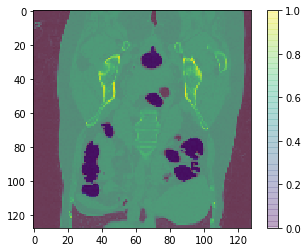

In [158]:
#determine that segmentation corresponds to CT
#as this was a considerable problem for a long time
plt.imshow(bx[2,:,63,:,0])
plt.imshow(by[2,:,63,:,0],alpha=0.2)
plt.colorbar()

In [ ]:
###########################################################################
# initial UNTESTED U-Net implementation

In [ ]:
NN = Model()
inp = Input((128,128,128,1))
learning_rate_decay = (0.001 - 0.00001) / 12

#contracting path
conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inp)
conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(drop1)

conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv2)
drop2 = Dropout(0.5)(conv2)

pool2 = MaxPooling3D(pool_size=(2, 2, 2))(drop2)

conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)
drop3 = Dropout(0.5)(conv3)

pool3 = MaxPooling3D(pool_size=(2, 2, 2))(drop3)

conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)

pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

#expansion path
up6 = UpSampling3D((2, 2, 2),data_format='channels_last')(conv5)
print(up6.shape)
up6 = concatenate([up6,drop4],axis=4)
print(up6.shape)
conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up6)
print(conv6.shape)
conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv6)
drop6 = Dropout(0.5)(conv6)


print(conv6.shape)
up7 = UpSampling3D((2, 2, 2),data_format='channels_last')(drop6)
up7 = concatenate([up7,drop3],axis=4)
conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up7)
conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv7)
drop7 = Dropout(0.5)(conv7)


print(conv7.shape)
up8 = UpSampling3D((2, 2, 2),data_format='channels_last')(drop7)
up8 = concatenate([up8,drop2],axis=4)
conv8 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up8)
conv8 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv8)
drop8 = Dropout(0.5)(conv8)


print(conv8.shape)
up9 = UpSampling3D((2, 2, 2),data_format='channels_last')(drop8)
up9 = concatenate([up9,inp],axis=4)
conv9 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(up9)
conv9 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(conv9)
drop9 = Dropout(0.5)(conv9)


print(conv9.shape)

conv10 = Conv3D(2, (1,1,1), activation='softmax', padding="same")(drop9)
print(conv10.shape)

out = Model(inputs=[inp], outputs=[conv10])

#out.summary()

In [ ]:
plot_model(out, to_file='model.png', show_shapes=True)

In [ ]:
out.compile(optimizer=keras.optimizers.adam(lr = 0.001,decay=learning_rate_decay), loss='binary_crossentropy', metrics=['accuracy'])
print(np.shape(X_train))

In [ ]:
out.fit_generator(trainingData, validation_data=validationData, epochs=12, verbose=1)
print("fitted!")

In [ ]:
import datetime

In [ ]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

#TODO make a path for this automatically
name = "model_" + timestamp + ".h5"
modelPath = os.path.join("E:\\Patient Data Summer\\NN\\Output\\", name)
model.save(modelPath)

In [ ]:
from keras.models import load_model

In [ ]:
trained_model = load_model(modelPath)
print(modelPath)

In [ ]:
outputSeg=trained_model.predict(np.array(X_test))

In [ ]:
#score = out.evaluate_generator(validationData)
outputSeg=out.predict(np.array(X_test))

In [ ]:
print(np.amin(outputSeg))
print(np.amax(outputSeg))

In [ ]:
binaryOutputSeg = (outputSeg > 0.5).astype(np.uint8)

In [ ]:
from mpl_toolkits import mplot3d

timestamp2 = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
ppath = os.path.join("E:\\Patient Data Summer\\NN\\Output\\", timestamp2 + ".npy")
np.save(ppath,outputSeg)

(1, 128, 128, 128, 1)


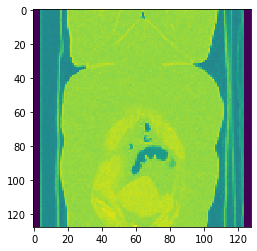

In [29]:
#original CT
lastNrrd=np.array(X_test)
print(np.shape(lastNrrd))
plt.imshow(lastNrrd[0,:,85,:,0])

In [ ]:
#human segmentation
lastSeg=np.array(y_test)
print(np.shape(lastSeg))
plt.imshow(lastSeg[0,:,85,:,0])
plt.colorbar()

In [ ]:
#output from running network
plt.imshow(np.array(outputSeg[0,:,85,:,1]))
plt.colorbar()

In [ ]:
#Neural network segmentation converted to binary
plt.imshow(np.array(binaryOutputSeg[0,:,80,:,0]))

In [ ]:
###########################################################################

In [80]:
num_classes = 2
filter_multiplier = 20

def nvidia_unet(input_size=128, num_classes=num_classes):
    input_ = Input((input_size, input_size, input_size, 1))
    skips = []
    output = input_
    c = num_classes
    
    num_layers = int(np.floor(np.log2(input_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)
    
    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int( (layer_index + 1) * filter_multiplier + num_classes )
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int( (num_layers - layer_index - 1) * filter_multiplier + num_classes )
    
    print("Number of layers:       {}".format(num_layers))
    print("Filters in layers down: {}".format(down_filter_numbers))
    print("Filters in layers up:   {}".format(up_filter_numbers))
    
    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output= Conv3D(filters, (shape, shape, shape), strides=2, padding="same", activation="relu")(output)
        
    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = keras.layers.UpSampling3D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=4)

        if filters != num_classes:
            output = Conv3D(filters, (shape, shape, shape), activation="relu", padding="same")(output)
            output = BatchNormalization(momentum=.9)(output)
        else:
            output = Conv3D(filters, (shape, shape, shape), activation="sigmoid", padding="same")(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet(size[0], num_classes)

# model.summary()

Number of layers:       7
Filters in layers down: [ 22  42  62  82 102 122 142]
Filters in layers up:   [122 102  82  62  42  22   2]


In [ ]:
plot_model(model, to_file='nvidiamodel.png', show_shapes=True)

In [81]:
max_learning_rate = 0.0001
min_learning_rate = 0.00001
num_epochs = 50

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=['accuracy'])

In [82]:
model.fit_generator(trainingData,
                    validation_data=validationData,
                    epochs=num_epochs,
                    verbose=1)

Epoch 1/50
25/25 [==============================] - 26s 1s/step - loss: 0.7026 - acc: 0.5878
Epoch 2/50
25/25 [==============================] - 20s 794ms/step - loss: 0.5824 - acc: 0.8324
Epoch 3/50
25/25 [==============================] - 19s 771ms/step - loss: 0.4662 - acc: 0.9384
Epoch 4/50
25/25 [==============================] - 20s 785ms/step - loss: 0.3879 - acc: 0.9512
Epoch 5/50
25/25 [==============================] - 21s 856ms/step - loss: 0.3292 - acc: 0.9638
Epoch 6/50
25/25 [==============================] - 20s 780ms/step - loss: 0.2835 - acc: 0.9741
Epoch 7/50
25/25 [==============================] - 20s 817ms/step - loss: 0.2444 - acc: 0.9812
Epoch 8/50
25/25 [==============================] - 20s 802ms/step - loss: 0.2133 - acc: 0.9833
Epoch 9/50
25/25 [==============================] - 20s 796ms/step - loss: 0.1849 - acc: 0.9853
Epoch 10/50
25/25 [==============================] - 20s 812ms/step - loss: 0.1643 - acc: 0.9858
Epoch 11/50
25/25 [=======================

In [74]:
y_pred = model.predict(np.array(X_test))

In [131]:
binaryOutputSeg2 = (y_pred > 0.5).astype(np.uint8)

In [126]:
pos=76

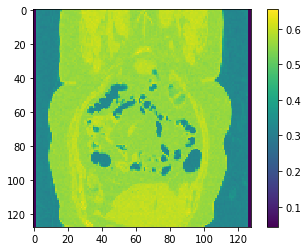

In [127]:
#original ct
plt.imshow(lastNrrd[0,:,pos,:,0])
plt.colorbar()

(1, 128, 128, 128, 1)


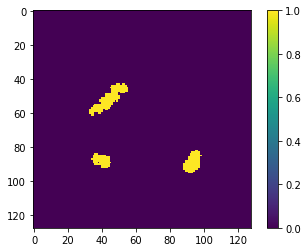

In [128]:
#human segmentation
lastSeg=np.array(y_test)
print(np.shape(lastSeg))
plt.imshow(lastSeg[0,:,pos,:,0])
plt.colorbar()

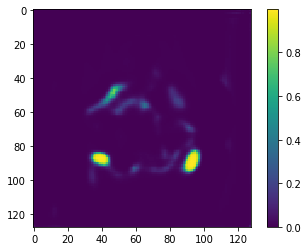

In [129]:
#output from network
plt.imshow(np.array(y_pred[0,:,pos,:,1]))
plt.colorbar()

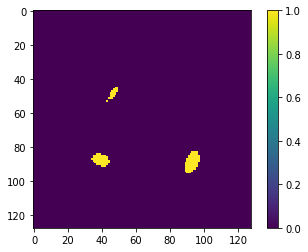

In [134]:
#thresholded output
#not representative of how the actual thresholded output will look as
#it is not adaptive, and i just chose 0.5 arbitrarily 
plt.imshow(np.array(binaryOutputSeg2[0,:,pos,:,1]))
plt.colorbar()

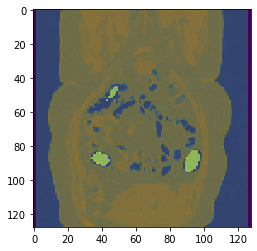

In [135]:
#thresholded network segmentation overlaid on CT
plt.imshow(lastNrrd[0,:,pos,:,0])
plt.imshow(np.array(binaryOutputSeg2[0,:,pos,:,1]),alpha=0.5)

In [ ]:
#TODO determine which U-Net implementation runs better
#TODO tidy up variable names
#TODO further improve accuracy
#TODO save as array and export to slicer
#TODO graph accuracy curve
#TODO highlight false positives and false negatives on binarizaed overlay
#TODO implement adaptive thresholding (if necessary)
#TODO clean up imports section